In [7]:
# sys tools
import sys
import time
import argparse

# data tools
import h5py
import zarr
import pygrib
import numpy as np
#import numba as nb
from datetime import datetime

# custom tools
#sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/utils/')
#sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/')
#sys.path.insert(0, '/glade/u/home/ksha/WORKSPACE/Analog_BC/utils/')
#import data_utils as du
#import analog_utils as ana

sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/')
sys.path.insert(0, '/glade/u/home/ksha/PUBLISH/WFRT-PP-DEV/libs/')

import nonDL_lib as nDL
import utils
from namelist_casper import * 


In [5]:
# -------- Function ends -------- #

# parser = argparse.ArgumentParser()
# parser.add_argument('year_fcst', help='year_fcst')
# parser.add_argument('part', help='part')
# args = vars(parser.parse_args())
# year_fcst = int(args['year_fcst'])
# part_ = int(args['part'])

EN = 25

dt_utc_now = datetime.utcnow()
dt_fmt_string = datetime.strftime(dt_utc_now, '%Y%m%d')
dt_day_of_year = dt_utc_now.timetuple().tm_yday
dt_month_from_zero = dt_utc_now.month-1
flag_leap_year = utils.leap_year_checker(dt_utc_now.year)

# ---------------------------------- #

# arg2
LEADs = np.arange(0, 54, dtype=np.int)
N_leads = len(LEADs)

In [8]:
year_analog = np.arange(2000, 2019)

# importing domain information
with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
    lat_bc = h5io['bc_lat'][...] # lats of the BC domain
    lon_bc = h5io['bc_lon'][...] # lons of the BC domain
    land_mask_bc = h5io['land_mask_bc'][...] # selecting OCEAN grids from the BC domain

ocean_mask_bc = np.logical_not(land_mask_bc) # selecting LAND grids from the BC domain

bc_shape = land_mask_bc.shape
N_grids = np.sum(ocean_mask_bc)

In [9]:
# supplemental locations
SL_xy_dict = {}
with h5py.File(save_dir+'SL20_d4_unique.hdf', 'r') as h5io:
    #IxIy_unique = h5io['unique_inds'][...]
    for i in range(12):
        temp = h5io['mon_{}_inds'.format(i)][...]
        temp = temp.astype(int)
        SL_xy_dict['{}'.format(i)] = temp
#IxIy_unique = IxIy_unique.astype(int)
SL_xy = tuple(SL_xy_dict.values())

In [10]:
AnEn_out = np.empty((N_leads, N_grids, EN))

In [11]:
#lead = LEADs[1]
for i, lead in enumerate(LEADs):
    lead_int_h = int(FCSTs[lead])
    print("Processing lead time = {}".format(lead))
    #print("Main program starts ...")
    # ------------------------------------------------- #
    
    # Import reforecast
    APCP = ()
    PWAT = ()
    
    for year in year_analog:
        apcp_temp = zarr.load(BASE_dir+'BASE_APCP_year{}_lead{}.zarr'.format(year, lead))
        pwat_temp = zarr.load(BASE_dir+'BASE_PWAT_year{}_lead{}.zarr'.format(year, lead))
        
        APCP += (apcp_temp,)
        PWAT += (pwat_temp,)
        
    # ------------------------------------------------- #
    
    # Import reanalysis
    ERA5 = ()
    
    for year in year_analog:
        era_temp = zarr.load(BASE_dir+'BASE_ERA5_year{}_lead{}.zarr'.format(year, lead))
        
        ERA5 += (era_temp,)
        
    # ------------------------------------------------- #
    
    GEFS_dir_base = '/glade/scratch/ksha/DATA/GEFS/{}/'.format(dt_fmt_string)
    GEFS_dir_full = GEFS_dir_base+'geavg.t00z.pgrb2s.0p25.f{0:03d}'.format(lead_int_h)
    
    with pygrib.open(GEFS_dir_full) as grb_io:
        #
        grb_reader_apcp = grb_io.select(name='Total Precipitation')[0]
        apcp, _, _ = grb_reader_apcp.data(lat1=48.25, lat2=60.00, lon1=-141.0+360, lon2=-113.25+360)
        apcp = np.flipud(apcp) # GEFS default: kg/m**-2 (or mm) per 3 hours
        
        #
        grb_reader_pwat = grb_io.select(name='Precipitable water')[0]
        pwat, _, _ = grb_reader_pwat.data(lat1=48.25, lat2=60.00, lon1=-141.0+360, lon2=-113.25+360)
        pwat = np.flipud(pwat) # GEFS default: kg/m**-2 (or mm) per 3 hours
    
    apcp_flat = apcp[ocean_mask_bc]
    pwat_flat = apcp[ocean_mask_bc]
    
    start_time = time.time()
    AnEn = nDL.analog_search_SL_single_day(dt_day_of_year, year_analog, apcp_flat, pwat_flat, APCP, PWAT, ERA5, EN, SL_xy, flag_leap_year)
    #print("... Completed. Time = {} sec ".format((time.time() - start_time)))
    
    AnEn_out[i, ...] = AnEn

Processing lead time = 0
Processing lead time = 1
Processing lead time = 2
Processing lead time = 3
Processing lead time = 4
Processing lead time = 5
Processing lead time = 6
Processing lead time = 7
Processing lead time = 8
Processing lead time = 9
Processing lead time = 10
Processing lead time = 11
Processing lead time = 12
Processing lead time = 13
Processing lead time = 14
Processing lead time = 15
Processing lead time = 16
Processing lead time = 17
Processing lead time = 18
Processing lead time = 19
Processing lead time = 20
Processing lead time = 21
Processing lead time = 22
Processing lead time = 23
Processing lead time = 24
Processing lead time = 25
Processing lead time = 26
Processing lead time = 27
Processing lead time = 28
Processing lead time = 29
Processing lead time = 30
Processing lead time = 31
Processing lead time = 32
Processing lead time = 33
Processing lead time = 34
Processing lead time = 35
Processing lead time = 36
Processing lead time = 37
Processing lead time =

In [13]:
AnEn_out.shape

(54, 2574, 25)

# MDSS

In [14]:
year_mdss = np.arange(2010, 2019)

In [16]:
start_time = time.time()

ERA5_mdss = ()

window_day = 30
N_days = window_day*2 + 1

# loop over years for MDSS training
for year in year_mdss:
    
    # separate leap year
    if utils.leap_year_checker(year):
        flag_pick = nDL.search_nearby_days(dt_day_of_year, window=30, leap_year=True)
    else:
        flag_pick = nDL.search_nearby_days(dt_day_of_year, window=30, leap_year=False)
        
    flag_pick = flag_pick == 1
    era_all_lead = np.empty((N_days, N_grids, N_leads))
    
    # loop over lead times
    for i, lead in enumerate(LEADs):
        era_temp = zarr.load(BASE_dir+'BC_ERA5_year{}_lead{}.zarr'.format(year, lead))
        era_all_lead[..., i] = era_temp[flag_pick, :]
    
    ERA5_mdss += (era_all_lead,)

ERA5_mdss = np.concatenate(ERA5_mdss)

print("... Completed. Time = {} sec ".format((time.time() - start_time)))

... Completed. Time = 147.41656613349915 sec 


In [17]:
AnEn_out = np.transpose(AnEn_out, (2, 0, 1))
ERA5_mdss = np.transpose(ERA5_mdss, (0, 2, 1))

In [18]:
# save_dict = {'AnEn_out': AnEn_out, 'ERA5_mdss': ERA5_mdss}
# np.save('test.npy', save_dict)

# temp_data = np.load('test.npy', allow_pickle=True)[()]
# AnEn_out = temp_data['AnEn_out']
# ERA5_mdss = temp_data['ERA5_mdss']

In [19]:
flag_pick = nDL.search_nearby_days(dt_day_of_year, window=30, leap_year=True)

We need to cut ~500 to 25 meanwhile minimizing the distribution divergence.

In [20]:
#CDF_fcst = CDF_estimate(AnEn_out)
#CDF_ERA5 = CDF_estimate(ERA5_mdss)
#record = total_divergence(CDF_ERA5, CDF_fcst)

In [21]:
start_time = time.time()
flag_clean, count_trial = nDL.MDSS_main(ERA5_mdss, AnEn_out, factor=5, max_trial=10000)
print("... Completed. Time = {} sec ".format((time.time() - start_time)))

... Completed. Time = 64.46895170211792 sec 


In [22]:
ERA5_pick = ERA5_mdss[flag_clean][:EN, ...]

In [23]:
# CDF_fcst = CDF_estimate(AnEn_out)
# CDF_ERA5 = CDF_estimate(ERA5_pick)
# total_divergence(CDF_ERA5, CDF_fcst)

In [24]:
# for i in range(200):
#     plt.figure()
#     plt.plot(CDF_fcst[:, 0, i])
#     plt.plot(CDF_ERA5[:, 0, i])

In [25]:
AnEn_MDSS_out = nDL.schaake_shuffle(AnEn_out, ERA5_pick)

In [26]:
AnEn_MDSS_out.shape

(25, 54, 2574)

In [27]:
anen_grid = np.empty((EN, N_leads,)+bc_shape)
#temp_grid = np.empty(bc_shape)
for en in range(EN):
    for l in LEADs:
        anen_grid[en, l, ocean_mask_bc] = AnEn_MDSS_out[en, l, :]
anen_grid[..., land_mask_bc] = np.nan

**MDSS**

In [30]:
AnEn.shape

(2574, 25)

In [31]:
# importing domain information
# with h5py.File(save_dir+'BC_domain_info.hdf', 'r') as h5io:
#     land_mask = h5io['land_mask_base'][...]
#     land_mask_bc = h5io['land_mask_bc'][...]
# bc_in_base = np.ones(land_mask.shape).astype(bool)
# bc_in_base[bc_inds[0]:bc_inds[1], bc_inds[2]:bc_inds[3]] = land_mask_bc

# # subsetting by land mask
# bc_shape = land_mask_bc.shape
# grid_shape = land_mask.shape
# IND_bc = []
# for i in range(grid_shape[0]):
#     for j in range(grid_shape[1]):
#         if ~bc_in_base[i, j]:
#             IND_bc.append([i, j])
# IND_bc = np.array(IND_bc, dtype=np.int)
# N_grids = len(IND_bc)

In [28]:
# graph tools
import cmaps
import cartopy.crs as ccrs
import cartopy.mpl.geoaxes
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.collections import PatchCollection

from matplotlib import ticker
import matplotlib.ticker as mticker
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

%matplotlib inline

In [30]:
# for i in range(54):
#     plt.figure()
#     plt.pcolormesh(lon_bc, lat_bc, anen_grid[5, i, ...], vmin=0, vmax=5, cmap=plt.cm.nipy_spectral_r)

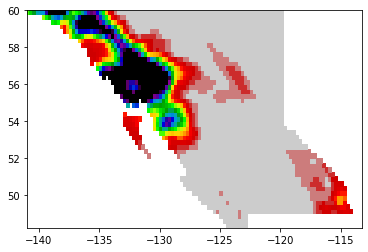

In [22]:
plt.pcolormesh(lon_bc, lat_bc, fcst_grid, vmin=0, vmax=5, cmap=plt.cm.nipy_spectral_r)

In [58]:
apcp.shape

(48, 112)

In [15]:
GEFS_dir = '/glade/scratch/ksha/DATA/GEFS/20220114/geavg.t00z.pgrb2s.0p25.f{0:03d}'.format(9)

In [16]:
GEFS_dir

'/glade/scratch/ksha/DATA/GEFS/20220114/geavg.t00z.pgrb2s.0p25.f009'

In [ ]:



    # ------------------------------------------------- #
    print("AnEn search starts ...")
    start_time = time.time()
    AnEn = analog_search_SL(day0, day1, year_analog, fcst_apcp, fcst_pwat, APCP, PWAT, ERA5, SL_xy, IxIy_unique, flag_leap_year)
    print("... Completed. Time = {} sec ".format((time.time() - start_time)))
    
#     # ------------------------------------------------- #
#     print("SG filter starts ...")
#     start_time2 = time.time()
